In [34]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from operator import itemgetter
import itertools 
import datetime
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore") 

Please enter the method to explore (Bus or Rail): Rail
Enter enter the method to exclude (Bus or Rail): Bus


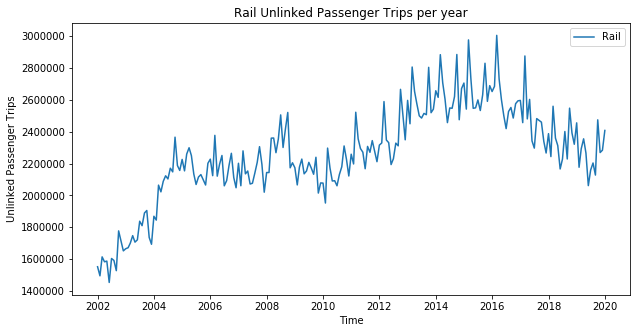

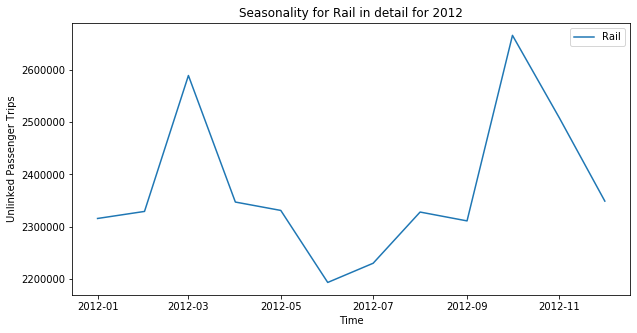

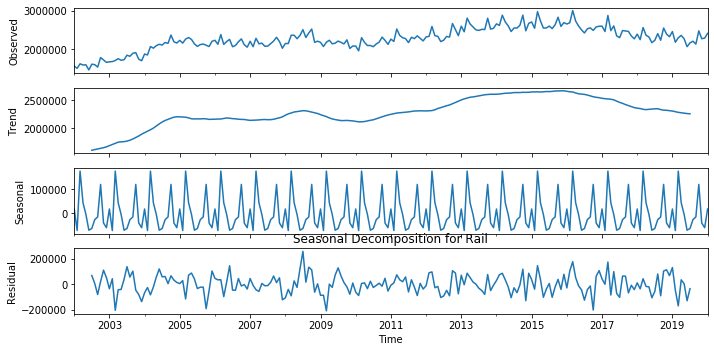

ValueError: min() arg is an empty sequence

In [40]:
method = (input('Please enter the method to explore (Bus or Rail): '))
method2drop = (input('Enter enter the method to exclude (Bus or Rail): '))
hurricanes_rail = ['2017-09-01', '2005-10-01']
hurricanes_bus = '2017-09-01'

def acquire ():
    data = pd.read_excel('c:/Users/denis/Desktop/Ironhack/ironhackLabs/Transportation/Users_Monthly.xlsx')
    return data

def wrangle(df):
    df = df[df['UZA Name'] == 'Miami, FL']
    df = df[df['Agency'] == 'Miami-Dade Transit']
    df = df.drop(['5 digit NTD ID', 'UZA', 'Unnamed: 226'], axis=1)
    df = df.groupby('Modes').sum()
    df = df.T
    df = df.reset_index()
    df = df.rename(columns={"index": "Time"})
    df['Time'] = pd.to_datetime(df['Time'], format='%b%y')
    df = df.set_index(['Time'], drop=True)
    df = df.drop([method2drop], axis=1)
    if method == 'Rail':
        for x in hurricanes_rail: 
            df_temp = df.reset_index()
            xloc = df_temp[df_temp["Time"]==pd.to_datetime(x)].index[0]
            avgBus = (df_temp["Rail"][xloc-1] + df_temp["Rail"][xloc+1])/2
            df.loc[x] = avgBus
    elif method == 'Bus': 
        df_temp = df.reset_index()
        xloc = df_temp[df_temp["Time"]==pd.to_datetime(hurricanes_bus)].index[0]
        avgBus = (df_temp["Bus"][xloc-1] + df_temp["Bus"][xloc+1])/2
        df.loc[hurricanes_bus] = avgBus
    filtered = df
    return filtered 

def visualize(df):
    # This graph will show how the number of unlinked passengers have changed through the years
    ax = sns.lineplot(data=df)
    ax.set_title(method + ' Unlinked Passenger Trips per year')
    ax.set_ylabel('Unlinked Passenger Trips')
    plt.show()
    # This graph will show you the seasonal trend of one year, particularly 2012 
    oneyear = df.loc['2012']
    ax2 = sns.lineplot(data=oneyear)
    ax2.set_title('Seasonality for ' + method +' in detail for 2012')
    ax2.set_ylabel('Unlinked Passenger Trips')
    plt.show()
    # This graph shows the seasonal decomposition 
    plt.rcParams['figure.figsize'] = [10, 5]
    result = seasonal_decompose(df[method])
    result.plot()
    pyplot.title('Seasonal Decomposition for ' + method)
    pyplot.savefig('seasonal_decompose.png')
    pyplot.show()
#     return graphs

def analyze(df):
    # Create Training and Test at 80% // 20%. Should standardize this for final code! 
    train = df[:174]
    test = df[174:]
    #We will perform a grid search depending on method chosen, to find the best parameters for the SARIMAX
    if method == 'Bus':
        new = []
        p = range(0,3)
        q = range(0,3)
        d = range(1,2)
        s = range(12,13)
        # list of all parameter combos
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = list(itertools.product(p, d, q, s))
        # SARIMA model pipeline
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = SARIMAX(train, order=param, seasonal_order=param_seasonal, disp=0)
                    results = mod.fit(max_iter = 50, method = 'powell', disp=0)
                    new.append({'Param': param, 'S_Param': param_seasonal, 'AIC': results.aic})
                except:
                    continue
        min_bus = min(new, key=itemgetter('AIC'))
        print(min_bus)
    elif method == 'Rail': 
        new = []
        p = range(0,3)
        q = range(0,3)
        d = range(1,2)
        s = range(12,13)
        # list of all parameter combos
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = list(itertools.product(p, d, q, s))
        # SARIMA model pipeline
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = SARIMAX(train, order=param,seasonal_order=param_seasonal, disp=0)
                    results = mod.fit(max_iter = 50, method = 'powell', disp=0)
                    forecast = results.predict(start=1, end=int(len(df)))
                    df['Forecast'] = forecast
                    start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
                    date_list = pd.date_range('2020-02-01', freq='1M', periods=23)
                    data = pd.DataFrame(index=date_list, columns= df.columns)
                    data.index = data.index.map(lambda t: t.replace(day=1))
                    pred_uc = results.get_forecast(steps=66)
                    data['Future'] = pred_uc.predicted_mean
                    predictions = df[174:]
                    predictions = predictions.drop(['Future'], axis=1)
                    mape = np.mean(np.abs(predictions["Forecast"] - predictions["Rail"])/np.abs(predictions["Rail"]))
                    new.append({'Param': param, 'S_Param': param_seasonal, 'MAPE': mape}) 
                except:
                    continue
        min_bus = min(new, key=itemgetter('MAPE'))
        print(min_bus)
#     # We will plug the value from the grid search into the SARIMAX and plot the actual training values against what the
#     # model has predicted for the training values
#     model = SARIMAX(train, order=min_bus['Param'], seasonal_order=min_bus['S_Param'], enforce_stationarity=False, enforce_invertibility=False)
#     fitted = model.fit()
#     print(fitted.summary())
#     fig, ax = plt.subplots()
#     fig.set_size_inches(20, 10)
#     plt.plot(train)
#     fitted_df = fitted.fittedvalues[1:]
#     plt.plot(fitted_df, color='red')
#     plt.show() 
    
#     # We will use the model to forecast until the end of our data 
    
    
#     # Assessing the accuracy of model 
#     def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse})

# forecast_accuracy(fc, test.values)
#     return results


if __name__ == '__main__':
    data = acquire()
    filtered = wrangle(data)
    graphs = visualize(filtered)
    results = analyze(filtered)
    
#     results = analyze(filtered)
#     barchart = visualize(results)
#     save_viz(barchart)

In [187]:
miami = pd.read_excel('c:/Users/denis/Desktop/Ironhack/ironhackLabs/Transportation/Users_Monthly.xlsx')

# Data Cleaning

In [199]:
def mean(arr, n): 
    sum = 0
      
    for i in range(0, n): 
        sum = sum + arr[i] 
    return (sum / n)  
  
# Function to find standard  
# deviation of given array. 
def standardDeviation(arr, n): 
    sum = 0
      
    for i in range(0, n): 
        sum = (sum + (arr[i] - mean(arr, n)) *
                      (arr[i] - mean(arr, n)))  
  
    return math.sqrt(sum / (n - 1))  
  
  
# Function to find coefficient 
# of variation. 
def coefficientOfVariation(arr, n): 
    return (standardDeviation(arr, n) /
                          mean(arr, n))

arr = miami_test['Rail'].array  
n = len(arr)
  
print(coefficientOfVariation(arr, n)) 

0.13413773903314805


# Data Visualization 

Note: Hurricane Irma occured Sept 2017, Wilma October 2005, and Katrina August 2005

In [15]:
#This used to show both Rail and Bus together in one graph, better to do it on Tableau

# import matplotlib.pyplot as plt

# fig, ax1 = plt.subplots()
# t = miami_test['Time']
# y1 = miami_test['Bus']
# ax1.plot(t, y1, 'b-')
# ax1.set_xlabel('time')

# ax2 = ax1.twinx()
# y2 = miami_test['Rail']
# ax2.plot(t, y2, 'r.')
# a,b = 0,8000000
# ax1.set_ylim(a,b)
# ax2.set_ylim(a,b)

# fig.tight_layout()
# plt.show()

# Dump -- Maybe for later

In [32]:
# miami_test.to_excel(r'c:/Users/denis/Desktop/Ironhack/ironhackLabs/Transportation/Miami_Tableau.xlsx', index=False)

# Grave of less fortunate, and thus unfeatured models

# Attempt 1: Stationarity via Log Transformation

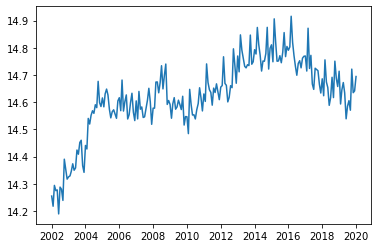

In [33]:
miami_test_logScale = np.log(miami_test)
plt.plot(miami_test_logScale)

In [34]:
movingavg = miami_test_logScale.rolling(window=12).mean()
movingstd = miami_test_logScale.rolling(window=12).std()

In [35]:
submovingavg = miami_test_logScale - movingavg
submovingavg.head()

submovingavg.dropna(inplace = True)

In [36]:
submovingavg.head()

Modes,Rail
Time,
2002-12-01,0.04
2003-01-01,0.04
2003-02-01,0.03
2003-03-01,0.05
2003-04-01,0.06


In [37]:
def test_stationarity(timeseries):

#Determing rolling stats
    movingAvg= timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

#plot rolling stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAvg, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='Black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#perform dickey-fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Rail'], autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statisitc', 'p-value', '#Lags USed', '# of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

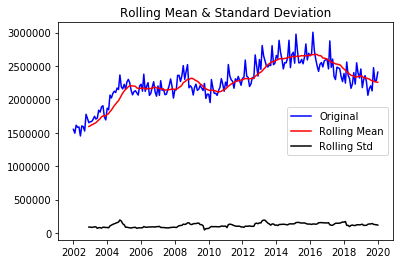

Results of Dickey-Fuller Test:
Test Statisitc            -2.63
p-value                    0.09
#Lags USed                14.00
# of Observations Used   202.00
Critical Value (1%)       -3.46
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [38]:
test_stationarity(miami_test)

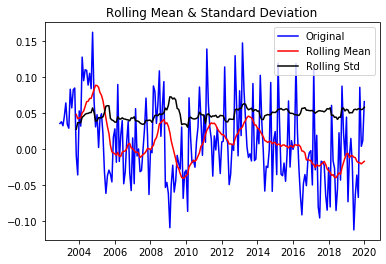

Results of Dickey-Fuller Test:
Test Statisitc            -3.42
p-value                    0.01
#Lags USed                14.00
# of Observations Used   191.00
Critical Value (1%)       -3.47
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [39]:
test_stationarity(submovingavg)

In [40]:
weightedAvg = miami_test_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
dfweightedAvg = miami_test_logScale - weightedAvg 

# Attempt 2: Stationarity via Differencing 

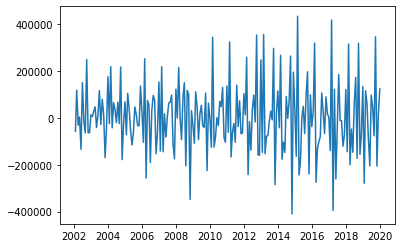

In [41]:
from matplotlib import pyplot
diff = miami_test.diff()
pyplot.plot(diff)
pyplot.show()

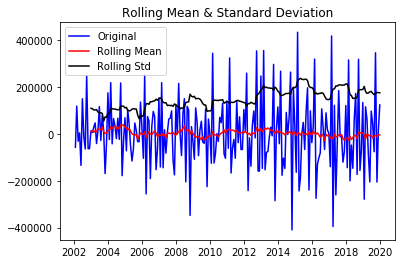

Results of Dickey-Fuller Test:
Test Statisitc            -3.43
p-value                    0.01
#Lags USed                15.00
# of Observations Used   200.00
Critical Value (1%)       -3.46
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [42]:
diff.dropna(inplace = True)
test_stationarity(diff)

In [33]:
# diff

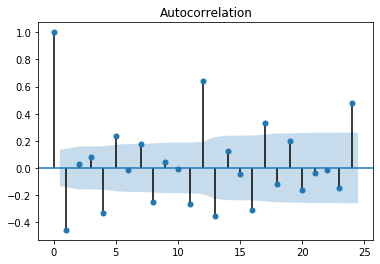

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(diff)
pyplot.show()

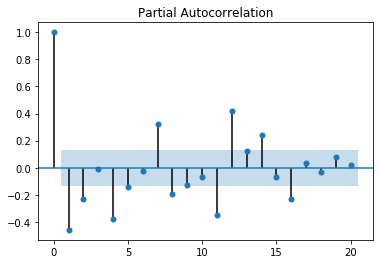

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff, lags=20)
pyplot.show()

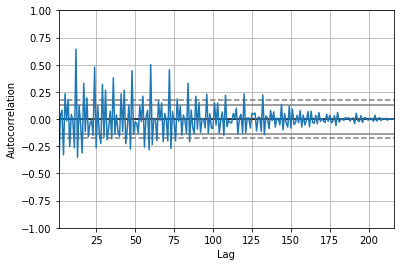

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff)
pyplot.show()

# Attempt 3: Stationarity via Second Differencing

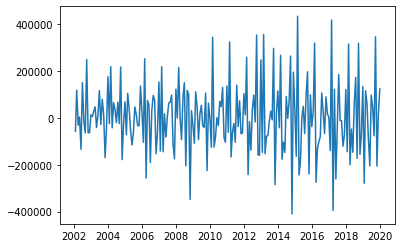

In [47]:
diff2 = miami_test.diff(periods=2)
pyplot.plot(diff)
pyplot.show()

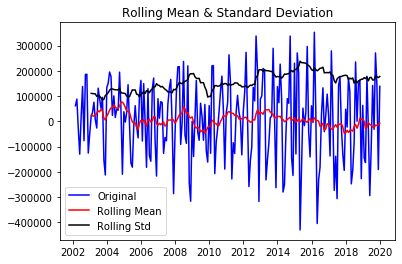

Results of Dickey-Fuller Test:
Test Statisitc            -3.39
p-value                    0.01
#Lags USed                14.00
# of Observations Used   200.00
Critical Value (1%)       -3.46
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [48]:
diff2.dropna(inplace = True)
test_stationarity(diff2)

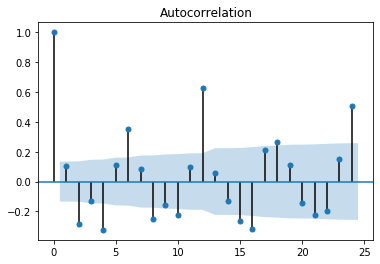

In [49]:
plot_acf(diff2)
pyplot.show()

# ARIMA models

                             ARIMA Model Results                              
Dep. Variable:                 D.Rail   No. Observations:                  216
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2840.201
Method:                       css-mle   S.D. of innovations         124080.243
Date:                Thu, 19 Mar 2020   AIC                           5692.403
Time:                        19:03:56   BIC                           5712.654
Sample:                    02-01-2002   HQIC                          5700.584
                         - 01-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3962.3379   2966.586      1.336      0.183   -1852.064    9776.739
ar.L1.D.Rail    -0.7905      0.128     -6.196      0.000      -1.041      -0.540
ar.L2.D.Rail    -0.0717      0.111     -0.64

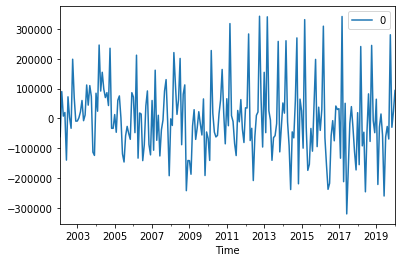

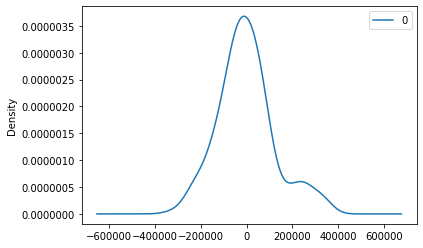

               0
count     216.00
mean    -1007.87
std    124414.15
min   -320453.45
25%    -71220.26
50%     -9136.87
75%     62211.31
max    342646.28


In [50]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(miami_test, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rail   No. Observations:                  216
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2842.157
Method:                       css-mle   S.D. of innovations         125225.621
Date:                Thu, 19 Mar 2020   AIC                           5692.314
Time:                        19:03:57   BIC                           5705.815
Sample:                    02-01-2002   HQIC                          5697.768
                         - 01-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3962.3379   2823.786      1.403      0.162   -1572.182    9496.857
ar.L1.D.Rail     0.0598      0.101      0.592      0.554      -0.138       0.258
ma.L1.D.Rail    -0.6923      0.072     -9.56

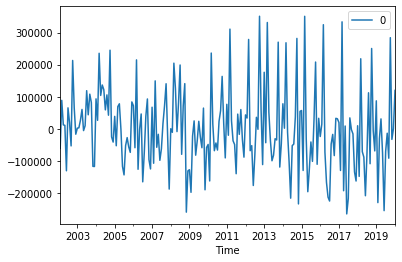

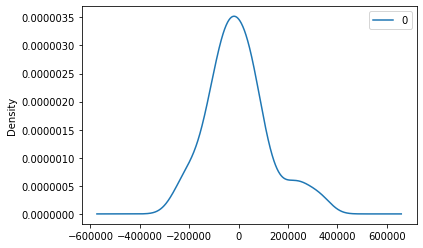

               0
count     216.00
mean    -1065.78
std    125554.40
min   -265522.24
25%    -78185.53
50%    -12535.68
75%     59979.72
max    350773.95


In [51]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(miami_test, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:                D2.Rail   No. Observations:                  215
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -2837.523
Method:                       css-mle   S.D. of innovations         128393.446
Date:                Thu, 19 Mar 2020   AIC                           5685.046
Time:                        19:03:58   BIC                           5701.899
Sample:                    03-01-2002   HQIC                          5691.855
                         - 01-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -83.8677     78.931     -1.063      0.289    -238.570      70.835
ar.L1.D2.Rail    -0.5616      0.066     -8.450      0.000      -0.692      -0.431
ar.L2.D2.Rail    -0.2276      0.066     

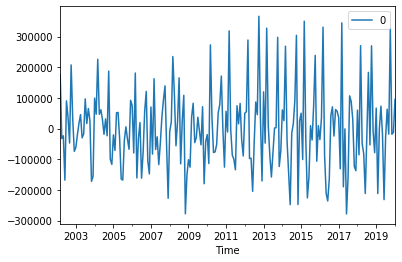

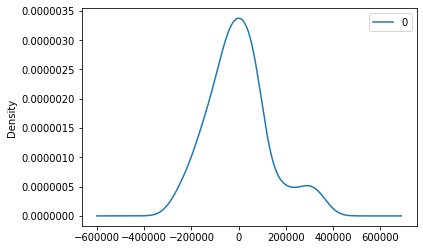

               0
count     215.00
mean     -141.12
std    130076.17
min   -278165.21
25%    -82050.16
50%    -11133.46
75%     61838.93
max    366308.76


In [52]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(miami_test, order=(2,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

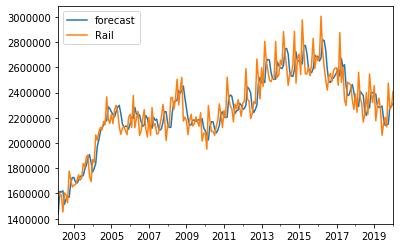

In [53]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Itertools for Optimization 

In [54]:
# import itertools
# p=d=q=range(0,13)
# pdq = list(itertools.product(p,d,q))

In [55]:
#This code freezes computer
# new = []
# for param in pdq:
#     try:
#         model = ARIMA(train, order=param)
#         fitted = model.fit()
#         fc, se, conf = fitted.forecast(54, alpha=0.05)
#         mape = np.mean(np.abs(fc - test.values)/np.abs(test.values)) 
#         new.append({param : mape})
#     except:
#         continue
        

In [56]:
# new

In [57]:
# new = {k:v for element in new for k,v in element.items()}

In [58]:
# {k: v for k, v in sorted(new.items(), key=lambda item: item[1])}

In [59]:
#Code below doesn't work 
# temp = min(new.values()) 
# res = [key for key in new if new[key] == temp] 
  
# # printing result  
# print("Keys with minimum values are : " + str(res))

# Training the model

In [175]:
from statsmodels.tsa.stattools import acf

# Create Training and Test at 80% // 20%. Should standardize this for final code! 
train = miami_test[:174]
test = miami_test[174:]

In [61]:
model = ARIMA(train, order=(1,1, 1))  
fitted = model.fit()  

In [24]:
# train

In [63]:
fc, se, conf = fitted.forecast(43, alpha=0.05)  # 95% conf

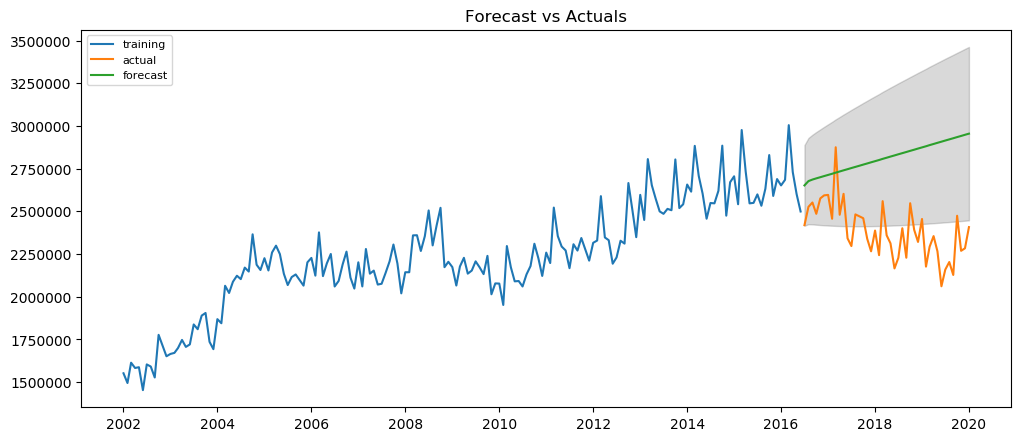

In [64]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
# predictions = fitted.forecast(64)[0]

In [66]:
# predictions

In [67]:
print(fitted.aic)

4547.439084961434


In [68]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
# ?                    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': 0.18662528072719006,
 'me': 429796.45039658877,
 'mae': 433229.300439103,
 'mpe': 0.18543144483323495,
 'rmse': 465725.10646503186}

# Trying different models

In [69]:
model = ARIMA(train, order=(2,2, 0))  
fitted = model.fit()  

In [70]:
fc, se, conf = fitted.forecast(43, alpha=0.05)  # 95% conf

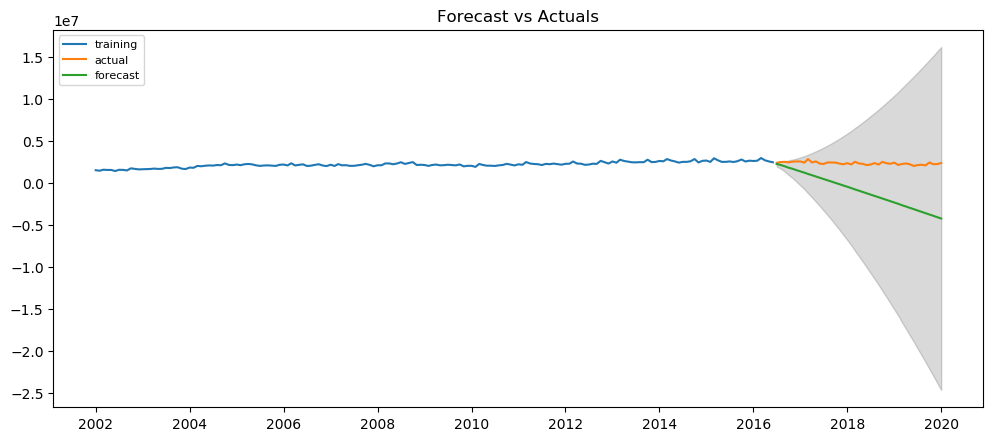

In [71]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [72]:
print(fitted.aic)

4607.354915376044


In [73]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': 1.383238899841477,
 'me': -3291862.70524056,
 'mae': 3293259.1587543003,
 'mpe': -1.3825888544603857,
 'rmse': 3817478.505182482}

# Grid Search -- SARIMA

In [129]:
import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(1,2)
s = range(12,13)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            forecast = results.predict(start=1, end=int(len(miami_test)))
            miami_test['Forecast'] = forecast
            start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
            date_list = pd.date_range('2020-02-01', freq='1M', periods=23)
            data = pd.DataFrame(index=date_list, columns= miami_test.columns)
            data.index = data.index.map(lambda t: t.replace(day=1))
            pred_uc = results.get_forecast(steps=66)
            data['Future'] = pred_uc.predicted_mean
            predictions = miami_test[174:]
            predictions = predictions.drop(['Future'], axis=1)
            mape = np.mean(np.abs(predictions["Forecast"] - predictions["Rail"])/np.abs(predictions["Rail"]))
            print('SARIMA{},{} - MAPE:{}'.format(param, param_seasonal, mape))  
        except:
            continue

Optimization terminated successfully.
         Current function value: 12.076394
         Iterations: 2
         Function evaluations: 40
SARIMA(0, 1, 0),(0, 1, 0, 12) - MAPE:0.07535442725931116
Optimization terminated successfully.
         Current function value: 11.983417
         Iterations: 1
         Function evaluations: 25
SARIMA(0, 1, 0),(0, 1, 1, 12) - MAPE:0.11515010852554866
Optimization terminated successfully.
         Current function value: 11.966530
         Iterations: 3
         Function evaluations: 113
SARIMA(0, 1, 0),(0, 1, 2, 12) - MAPE:0.11531644214102692
Optimization terminated successfully.
         Current function value: 12.007872
         Iterations: 2
         Function evaluations: 49
SARIMA(0, 1, 0),(1, 1, 0, 12) - MAPE:0.09860803619214105
Optimization terminated successfully.
         Current function value: 11.960464
         Iterations: 4
         Function evaluations: 157
SARIMA(0, 1, 0),(1, 1, 1, 12) - MAPE:0.11482844935903924
Optimization terminated

Optimization terminated successfully.
         Current function value: 11.950501
         Iterations: 3
         Function evaluations: 174
SARIMA(1, 1, 1),(2, 1, 0, 12) - MAPE:0.11078977391239399
Optimization terminated successfully.
         Current function value: 11.914870
         Iterations: 4
         Function evaluations: 287
SARIMA(1, 1, 1),(2, 1, 1, 12) - MAPE:0.1231752449524435
Optimization terminated successfully.
         Current function value: 11.913116
         Iterations: 5
         Function evaluations: 410
SARIMA(1, 1, 1),(2, 1, 2, 12) - MAPE:0.1272032882923819
Optimization terminated successfully.
         Current function value: 12.032053
         Iterations: 2
         Function evaluations: 93
SARIMA(1, 1, 2),(0, 1, 0, 12) - MAPE:0.09265215219738697
Optimization terminated successfully.
         Current function value: 11.933216
         Iterations: 3
         Function evaluations: 182
SARIMA(1, 1, 2),(0, 1, 1, 12) - MAPE:0.12260563299067412
Optimization terminated

In [134]:
import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(1,2)
s = range(12,13)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [79]:
# SARIMA(0, 1, 1),(1, 1, 1, 12) - AIC:4225.978265791773

# Himanshu's Sarima

In [ ]:
# train order=(2,1,0), seasonal_order=(0,1,1,12)

                                 Statespace Model Results                                 
Dep. Variable:                                Bus   No. Observations:                  174
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -2092.309
Date:                            Fri, 20 Mar 2020   AIC                           4190.619
Time:                                    01:15:02   BIC                           4199.631
Sample:                                01-01-2002   HQIC                          4194.280
                                     - 06-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5093      0.065     -7.793      0.000      -0.637      -0.381
ar.S.L12      -0.3915      0.074   

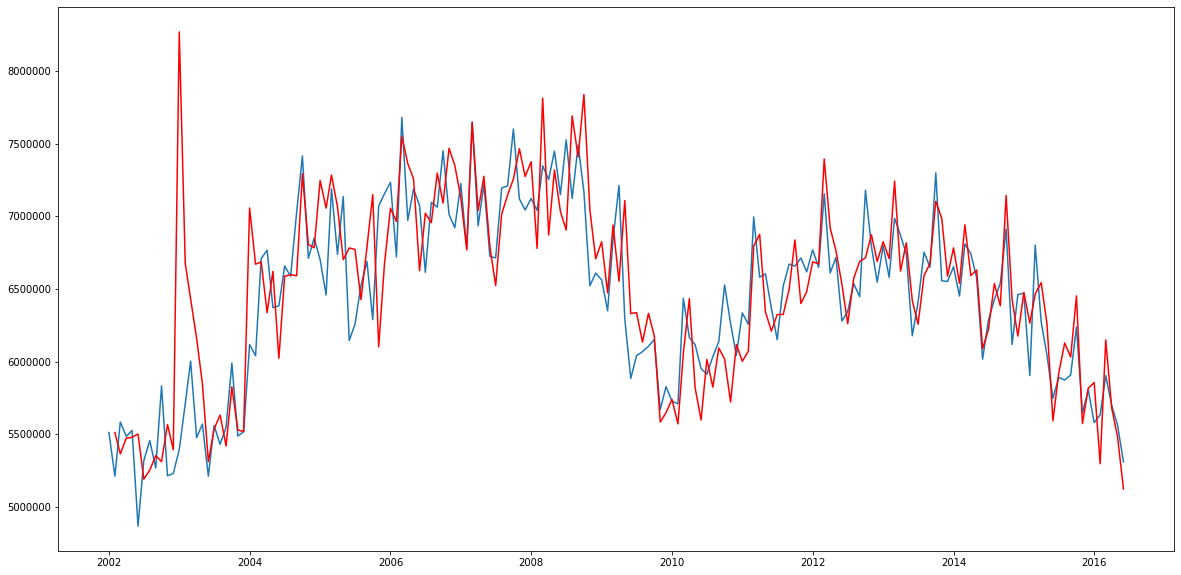

In [176]:
model = SARIMAX(train, order=(0,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
fitted = model.fit()
print(fitted.summary())
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(train)
fitted_df = fitted.fittedvalues[1:]
plt.plot(fitted_df, color='red')
plt.show() 

In [177]:
forecast = fitted.predict(start=1, end=int(len(miami_test)))
# forecast

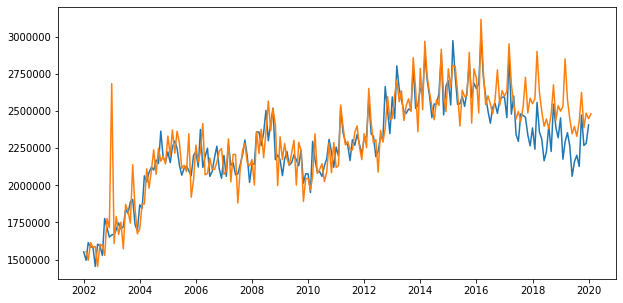

In [149]:
# plot the predictions for validation set
# Make it tableau 
#Make calcuated field and then can color based on that calcuated field. if / else 
plt.plot(miami_test, label='Train')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
# forecastt = fitted.predict(start=174, end=int(len(test)))
# forecastt

In [ ]:
# miami_test['Forecast'] = forecast
# miami_test[['Bus', 'Forecast']].plot(figsize=(16, 12))  
# # data['Forecast'] = fitted.forecast(100) 
# # data[['Price', 'Forecast']].plot(figsize=(12, 8))

In [ ]:
# import datetime
# start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
# date_list = pd.date_range('2020-02-01', freq='1M', periods=23)
# # future = pd.DataFrame(index=date_list, columns= miami_test.columns)
data = pd.concat([miami_test, future])

In [181]:
#combined all datasets for Tableau
import datetime
miami_test['Forecast'] = forecast
start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
date_list = pd.date_range('2020-02-01', freq='1M', periods=23)
future = pd.DataFrame(index=date_list, columns= miami_test.columns)
future.index = future.index.map(lambda t: t.replace(day=1))
pred_uc = fitted.get_forecast(steps=66)
future['Future'] = pred_uc.predicted_mean
data = pd.concat([miami_test, future])
# data.tail(12)

In [160]:
data

,Forecast,Future,Rail
2002-01-01,nan,nan,1551952.00
2002-02-01,1551952.00,nan,1494895.00
2002-03-01,1494895.00,nan,1613905.00
2002-04-01,1613905.00,nan,1583007.00
2002-05-01,1583007.00,nan,1587454.00
2002-06-01,1587454.00,nan,1453326.00
2002-07-01,1453326.00,nan,1603810.00
2002-08-01,1603810.00,nan,1591425.00
2002-09-01,1591425.00,nan,1527310.00
2002-10-01,1527310.00,nan,1777054.00


In [161]:
data.to_excel(r'c:/Users/denis/Desktop/Ironhack/ironhackLabs/Transportation/Rail_F.xlsx')

In [182]:
predictions = miami_test[174:]

In [183]:
predictions = predictions.drop(['Future'], axis=1)

KeyError: "['Future'] not found in axis"

In [ ]:
# from statsmodels.tools.eval_measures import rmse
# error=rmse(predictions["Rail"], predictions["Forecast"])
# error

In [184]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
# ?                    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(predictions["Forecast"], predictions["Bus"])

{'mape': 0.04745269509682882,
 'me': 66002.12019956259,
 'mae': 219529.44398747582,
 'mpe': 0.013294247126930989,
 'rmse': 276301.5174782122}

In [165]:
fitted.aic

4179.717104800176

In [ ]:
# start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
# date_list = [start + relativedelta(months=x) for x in range(0,12)]
# future = pd.DataFrame(index=date_list, columns= miami_test.columns)
# df = pd.concat([miami_test, future])

# df['forecast'] = results.predict(start = 217, end = 229, dynamic= True)  
# df[['Bus', 'forecast']].ix[-24:].plot(figsize=(12, 8)) 
# # data['forecast'] = fitted.predict(start = 229, end = 250, dynamic= True)  
# # data[['Bus', 'forecast']].ix[-24:].plot(figsize=(12, 8)) 

In [112]:
pred_uc = fitted.get_forecast(steps=66)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [ ]:
# pred_uc = fitted.get_forecast(start = datetime.datetime.strptime("2016"),
#                               end =datetime.datetime.strptime("2021"))

In [ ]:
pred_uc.predicted_mean

In [ ]:
ax = miami_test.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Untrained Model')
# fitted_df.plot(ax=ax, label='Trained Model')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('unlinked passenger trips')
# ax.ticklabel_format(useOffset=False)
# ax.set_ylim((-50000000, 5000000))
plt.legend()
plt.show()

In [ ]:
# K = len(test)
# forecast = model_fit.forecast(K)
# # forecast = np.exp(forecast)

# plt.figure(figsize=(10,5))
# plt.plot(forecast, 'r');
# plt.plot(miami_test, 'b');
# # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)));
# plt.xlabel('Years'); 
# plt.ylabel('Passangers');
# # plt.axvline(x=miami_test(split_point), color='black');